In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Dense, Conv1D, GlobalMaxPooling1D, Concatenate,Input, Dropout
from keras.models import Model

In [3]:
FILE_PATH_TRAIN = 'data/train.csv'

In [7]:
train_data = pd.read_csv(FILE_PATH_TRAIN,encoding='latin')
train_data = train_data[['SentimentText','Sentiment']]
display(train_data)

,SentimentText,Sentiment
0,is so sad for my APL frie...,0
1,I missed the New Moon trail...,0
2,omg its already 7:30 :O,1
3,.. Omgaga. Im sooo im gunna CRy. I'...,0
4,i think mi bf is cheating on me!!! ...,0
...,...,...
99984,@Cupcake seems like a repeating problem hop...,0
99985,@cupcake__ arrrr we both replied to each other...,1
99986,@CuPcAkE_2120 ya i thought so,0
99987,@Cupcake_Dollie Yes. Yes. I'm glad you had mor...,1


In [11]:
# data preprocessing
tweets = train_data['SentimentText'].values
labels = train_data['Sentiment'].values

def clean_tweet(input_text):
    # remove twitter handles (@user)
    tweet = re.sub(r'@[\w]*', ' ',input_text)
    
    # remove special characters, numbers, punctuations
    tweet = re.sub(r'[^a-zA-Z#]', ' ',tweet)
    
    # remove two or more spaces by one space
    tweet = re.sub(r' +', ' ',tweet)
    
    return tweet.strip()


tweets = [clean_tweet(tweet) for tweet in tweets]

print(tweets[-5:])

['seems like a repeating problem hope you re able to find something', 'arrrr we both replied to each other over different tweets at the same time i ll see you then Duno where the hell Kateyy is', 'ya i thought so', 'Yes Yes I m glad you had more fun with me', 'haha yes you do']


In [19]:
t = Tokenizer()
t.fit_on_texts(tweets)
sequences = t.texts_to_sequences(tweets)
word2idx = t.word_index
print('Number of unique words : {}'.format(len(word2idx)))

max_sequence_len = max([len(seq) for seq in sequences])
print('maximum sequence length : {}'.format(max_sequence_len))

data_inputs = pad_sequences(sequences,maxlen=max_sequence_len, padding='post')

Number of unique words : 52265
maximum sequence length : 121


In [31]:
max_vocab_size = len(word2idx) + 1
embedding_dim = 200
num_filters = 100
epochs = 5
batch_size =32 

In [30]:
#build model
embedding_layer = Embedding(max_vocab_size,embedding_dim)
inputs_  = Input(shape=(max_sequence_len,))
x = embedding_layer(inputs_)

bigram = Conv1D(num_filters, kernel_size=2,padding='valid',activation='relu')
pool_1 = GlobalMaxPooling1D()

trigram = Conv1D(num_filters, kernel_size=3,padding='valid',activation='relu')
pool_2 = GlobalMaxPooling1D()

fourgram = Conv1D(num_filters, kernel_size=4,padding='valid',activation='relu')
pool_3 = GlobalMaxPooling1D()

dense_1 = Dense(256,activation='relu')
dropout = Dropout(.3)

concatenator = Concatenate(axis=-1)

last_dense = Dense(1,activation='sigmoid')

x_1 = bigram(x)
x_1 = pool_1(x_1)

x_2 = trigram(x)
x_2 = pool_2(x_2)

x_3 = fourgram(x)
x_3 = pool_2(x_3)

merged = concatenator([x_1, x_2, x_3])
merged = dense_1(merged)
merged = dropout(merged)
outputs = last_dense(merged) 

model = Model(inputs=inputs_,outputs=outputs)
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 121)          0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 121, 200)     10453200    input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 120, 100)     40100       embedding_5[0][0]                
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 119, 100)     60100       embedding_5[0][0]                
____________________________________________________________________________________________

In [32]:
r = model.fit(data_inputs,
              labels,
              batch_size=batch_size,
              epochs=epochs,
              validation_split=.2)

c:\users\new.user\desktop\ml_env\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 79991 samples, validate on 19998 samples
Epoch 1/5
79991/79991 [==============================] - 1322s 17ms/step - loss: 0.4936 - accuracy: 0.7564 - val_loss: 0.4607 - val_accuracy: 0.7803
Epoch 2/5
79991/79991 [==============================] - 1156s 14ms/step - loss: 0.3516 - accuracy: 0.8453 - val_loss: 0.5007 - val_accuracy: 0.7717
Epoch 3/5
79991/79991 [==============================] - 1182s 15ms/step - loss: 0.1940 - accuracy: 0.9205 - val_loss: 0.6579 - val_accuracy: 0.7595
Epoch 4/5
79991/79991 [==============================] - 1149s 14ms/step - loss: 0.1040 - accuracy: 0.9580 - val_loss: 0.8316 - val_accuracy: 0.7528
Epoch 5/5
79991/79991 [==============================] - 1206s 15ms/step - loss: 0.0712 - accuracy: 0.9719 - val_loss: 0.9550 - val_accuracy: 0.7340


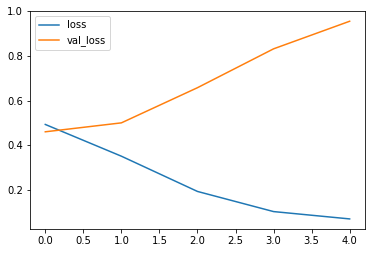

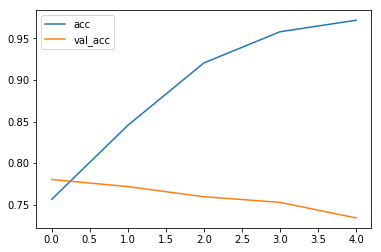

In [34]:
# plot loss data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# plot accuracies  data
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()